<a href="https://colab.research.google.com/github/khs05109/-AI-/blob/main/NewsTopicClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 환경 세팅


In [ ]:
!pip install transformers
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [ ]:
import sys
import numpy as np
import pandas as pd
import random
import os
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

# tokenizer
import transformers
from transformers import BertTokenizer,AdamWeightDecay,TFRobertaModel,TFBertModel

# 딥러닝 모델
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

# 머신러닝 모델
import sklearn
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

# EDA 분석 및 visualization
from wordcloud import WordCloud
import konlpy
from konlpy.tag import Mecab, Okt

# selenium을 이용한 back translation
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
# Set path
# PATH = '/content/drive/Shareddrives/인공지능/dacon/open/'

# google drive내의 경로와 연결
data_path='/content/drive/Shareddrives/인공지능/dacon/open/'
model_path='/content/drive/Shareddrives/인공지능/dacon/model/'
sub_path='/content/drive/Shareddrives/인공지능/dacon/sub/'

train = pd.read_csv(data_path + "train_data.csv", error_bad_lines=False )
test = pd.read_csv(data_path + "test_data.csv",error_bad_lines=False)
sample_submission=pd.read_csv(os.path.join(data_path,'sample_submission.csv'))
topic_dict = pd.read_csv(data_path + "topic_dict.csv",error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Roberta 모델에서 사용되는 BertTokenizer
tokenizer = BertTokenizer.from_pretrained('klue/roberta-large')

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

# 2. EDA (데이터 분석)



*   train set 'title' 길이 정보




In [ ]:
titles = train['title']
idx = train['topic_idx']

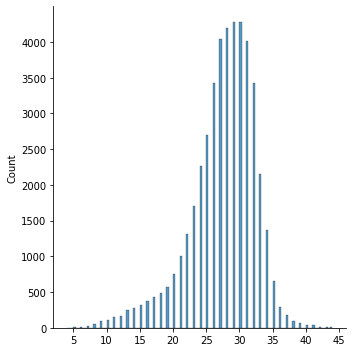

In [ ]:
train_len = [len(t) for t in titles]
sns.displot(train_len)



*   train set 단어 분포


In [ ]:
plt.rc('font',family='NanumBarunGothic')
Font_path = '/content/drive/Shareddrives/인공지능/dacon/font/NanumGothic.ttf'

In [ ]:
mecab = Mecab()
# for 형태소
counter_token = Counter()
# for 명사
counter_noun = Counter()

tokenized = [mecab.morphs(t) for t in titles]
for word in tokenized:
  counter_token.update(word)


noun_only = [mecab.nouns(t) for t in titles]
for noun in noun_only:
  counter_noun.update(noun)

(-0.5, 399.5, 199.5, -0.5)

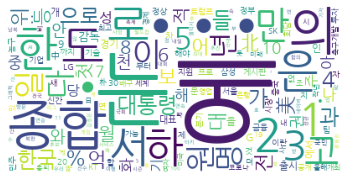

In [ ]:
# 전체 단어 분포 출력
# 형태소 단위 기준
wc_token = WordCloud(font_path = Font_path, background_color = "white")
cloud = wc_token.generate_from_frequencies(counter_token)
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

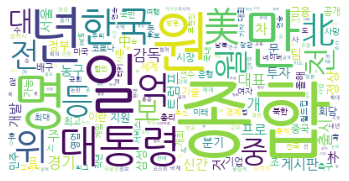

In [ ]:
# 명사 분포 출력
wc_noun = WordCloud(font_path = Font_path, background_color = "white")
cloud = wc_noun.generate_from_frequencies(counter_noun)
plt.imshow(cloud)
plt.axis('off')

In [ ]:
# Data Frame
df = []
for i in range(7):
  df.append(train.loc[train.topic_idx==i])

title_list = []
for i in range(7):
  title_list.append(df[i].title.to_numpy())

token_list = []
# 품사: 일반명사, 고유명사, 외국어, 한자
pos = ['NNP','NNG','SL','SH']

for i in range(7):
  title = title_list[i]
  tokens=[]
  for j in title:
    tmp=[]
    tmp = mecab.pos(j)
    for k in tmp:
      if k[1] in pos:
        tokens.append(k[0])
  token_list.append(tokens)

counter_list = []
for i in range(7):
  counter = Counter(token_list[i])
  counter_list.append(counter)

(-0.5, 399.5, 199.5, -0.5)

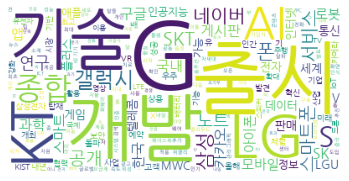

In [ ]:
# IT과학 (0)
wc0 = WordCloud(font_path = Font_path, background_color = "white")
cloud = wc0.generate_from_frequencies(counter_list[0])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

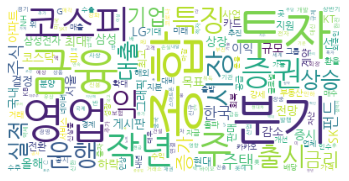

In [ ]:
# 경제 (1)
wc1 = WordCloud(font_path = Font_path, background_color = "white")
cloud = wc1.generate_from_frequencies(counter_list[1])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

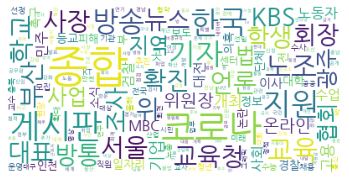

In [ ]:
# 사회 (2)
wc2 = WordCloud(font_path = Font_path, background_color = "white")
cloud = wc2.generate_from_frequencies(counter_list[2])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

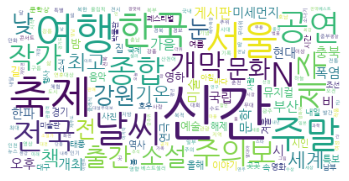

In [ ]:
# 생활문화 (3)
wc3 = WordCloud(font_path = Font_path, background_color = "white")
cloud = wc3.generate_from_frequencies(counter_list[3])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

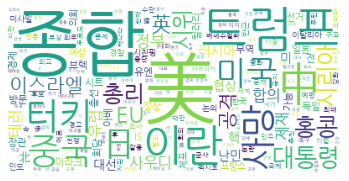

In [ ]:
# 세계 (4)
wc4 = WordCloud(font_path = Font_path, background_color = "white")
cloud = wc4.generate_from_frequencies(counter_list[4])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

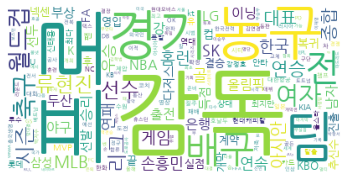

In [ ]:
# 스포츠 (5)
wc5 = WordCloud(font_path = Font_path, background_color = "white")
cloud = wc5.generate_from_frequencies(counter_list[5])
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

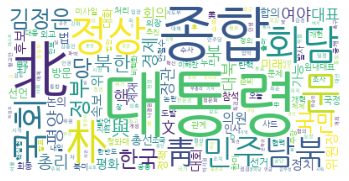

In [ ]:
# 정치 (6)
wc6 = WordCloud(font_path = Font_path, background_color = "white")
cloud = wc6.generate_from_frequencies(counter_list[6])
plt.imshow(cloud)
plt.axis('off')

# 3. 전처리

한자/영어를 한글로 대체

+ 영어는 제외함..

In [ ]:
# sns.displot(train.topic_idx)

In [ ]:
# train 데이터 카테고리별 균일화 
# titles_t = train.title.to_numpy().reshape(-1,1)
# labels_t = train.topic_idx.to_numpy().reshape(-1,1)
# oversample = RandomOverSampler()
# X_over, y_over = oversample.fit_resample(titles_t, labels_t)
# train = pd.DataFrame({'title':X_over.reshape(-1), 'topic_idx':y_over.reshape(-1)})

In [ ]:
# sns.displot(train.topic_idx)

In [ ]:
# 영어 빈도수 확인
en = []

for i in tokenized:
  for k in i:
    tmp = []
    tmp = mecab.pos(k)
    for j in tmp:
      if j[1] == 'SL':
        en.append(j[0])

Counter(en).most_common()[:50]

# 대부분 기업이름, 대회이름 등 고유명사임 -> 제거하지 않음

[('G', 750),
 ('LG', 734),
 ('KT', 576),
 ('SK', 553),
 ('S', 398),
 ('AI', 370),
 ('SKT', 308),
 ('MLB', 292),
 ('EU', 236),
 ('vs', 223),
 ('N', 199),
 ('TV', 188),
 ('NBA', 186),
 ('LGU', 183),
 ('KB', 179),
 ('KBS', 174),
 ('V', 168),
 ('K', 155),
 ('D', 154),
 ('IS', 148),
 ('U', 143),
 ('A', 133),
 ('GS', 117),
 ('MBC', 113),
 ('KBO', 112),
 ('SNS', 112),
 ('FA', 107),
 ('NH', 106),
 ('MWC', 100),
 ('X', 100),
 ('kt', 99),
 ('MVP', 91),
 ('KIA', 91),
 ('DB', 88),
 ('KIST', 88),
 ('OK', 87),
 ('CJ', 84),
 ('VR', 83),
 ('NC', 82),
 ('IoT', 76),
 ('ICT', 73),
 ('MOU', 70),
 ('RD', 69),
 ('PO', 68),
 ('EPL', 68),
 ('FC', 65),
 ('IT', 64),
 ('B', 62),
 ('LTE', 62),
 ('UAE', 58)]

In [ ]:
# 한자 빈도수 확인
titles = train['title']
hj=[]

for i in range(0, len(idx)):
  a = re.findall('[一-龥]', titles[i])
  if len(a) != 0:
    hj = [*hj,*a]


Counter(hj).most_common()[:40]

[('美', 1498),
 ('北', 1329),
 ('中', 795),
 ('朴', 661),
 ('日', 467),
 ('靑', 381),
 ('與', 291),
 ('英', 285),
 ('文', 184),
 ('野', 181),
 ('獨', 138),
 ('伊', 127),
 ('韓', 109),
 ('前', 95),
 ('佛', 92),
 ('檢', 73),
 ('軍', 69),
 ('安', 63),
 ('反', 54),
 ('行', 44),
 ('南', 37),
 ('硏', 27),
 ('故', 25),
 ('外', 24),
 ('亞', 23),
 ('對', 21),
 ('銀', 19),
 ('展', 19),
 ('重', 18),
 ('株', 18),
 ('新', 17),
 ('黃', 16),
 ('企', 14),
 ('詩', 14),
 ('車', 14),
 ('孫', 14),
 ('親', 13),
 ('黨', 13),
 ('人', 13),
 ('比', 12)]

In [ ]:
def replace_hanja(text):
  import re

  # 빈도수 최다(~40)
  text = re.sub("中", "중국", text)
  text = re.sub("美", "미국", text)
  text = re.sub("北", "북한", text)
  text = re.sub("日", "일본", text)
  text = re.sub("英", "영국", text)
  text = re.sub("行", "행", text)
  text = re.sub("靑", "청와대", text)
  text = re.sub("朴", "박", text)
  text = re.sub("銀", "은행", text)
  text = re.sub("與", "여당", text)
  text = re.sub("文", "문", text)
  text = re.sub("野", "야당", text)
  text = re.sub("獨", "독일", text)
  text = re.sub("伊", "이탈리아", text)
  text = re.sub("韓", "한국", text)
  text = re.sub("佛", "프랑스", text)
  text = re.sub("前", "전", text)
  text = re.sub("檢", "검찰", text)
  text = re.sub("軍", "군", text)
  text = re.sub("安", "안철수", text)
  text = re.sub("南", "남한", text)
  text = re.sub("亞", "아시아", text)
  text = re.sub("反", "반대", text)
  text = re.sub("故", "사망", text)
  text = re.sub("新", "새로운", text)
  text = re.sub("硏", "연구", text)
  text = re.sub("展", "전시회", text)
  text = re.sub("重", "차", text)
  text = re.sub("株", "주식", text)
  text = re.sub("詩", "시", text)
  text = re.sub("孫", "손학규", text)
  text = re.sub("親", "친", text)
  text = re.sub("黨", "당", text)

  text = re.sub("比", "대비", text)

  # 추가
  text = re.sub("外人", "외국인", text)
  if re.search(r"[0-9]人", text):
     text = re.sub("人", "명", text)
  text = re.sub("人", "사람", text)
  text = re.sub("中企", "중소기업", text)
  text = re.sub("印尼", "인도네시아", text)

  return text

In [ ]:
# def replace_special_symbol(text):
#   import re

#   #특수문자 대치 
  # text = re.sub(".", " ", text)
  # text = re.sub("→", " ", text)
  # text = re.sub(",", " ", text)
  # text = re.sub("↑", " ", text)
  # text = re.sub("↓", " ", text)
  # text = re.sub("·", " ", text)
  # text = re.sub("①", " ", text)
  # text = re.sub("②", " ", text)
  # text = re.sub("③", " ", text)
  # text = re.sub("④", " ", text)
  # text = re.sub("⑤", " ", text)
  # text = re.sub("⑥", " ", text)
  # text = re.sub("⑦", " ", text)
  # text = re.sub("⑧", " ", text)
  # text = re.sub("⑨", " ", text)
  # text = re.sub("⑩", " ", text)

#   return text

In [ ]:
train["title"] = train["title"].apply(replace_hanja)

In [ ]:
# train["title"] = train["title"].apply(replace_special_symbol)

In [ ]:
def isCountry(text):
  for name in COUNTRIES:
    val = text.find(name)

    # 나라이름이 포함되어있을 때
    if val != -1:
      return True
  
  return False

나라 이름 

In [ ]:
COUNTRIES = [
        "말리",
        "마카오",
        "쿠바",
        "프랑스",
        "이스라엘",
        "나이지리아",
        "뉴질랜드",
        "카메룬",
        "팔레스타인",
        "브라질",
        "벨기에",
        "콩고",
        "바레인",
        "이라크",
        "요르단",
        "기니",
        "시리아",
        "소말리아",
        "스웨덴",
        "슬로바키아",
        "태국",
        "레바논",
        "이집트",
        "러시아",
        "그리스",
        "독일",
        "아르헨티나",
        "알제리",
        "말레이시아",
        "홍콩",
        "적도",
        "인도네시아",
        "파키스탄",
        "부르키나파소",
        "중국",
        "카자흐스탄",
        "오스트리아",
        "수단",
        "대한민국",
        "콜롬비아",
        "케냐",
        "노르웨이",
        "키르기스스탄",
        "파나마",
        "몰타",
        "세르비아",
        "스페인",
        "모나코",
        "영국",
        "볼리비아",
        "리비아",
        "핀란드",
        "헝가리",
        "네덜란드",
        "인도",
        "지브롤터",
        "짐바브웨",
        "키프로스",
        "페루",
        "칠레",
        "마다가스카르",
        "아일랜드",
        "우간다",
        "캐나다",
        "베트남",
        "베네수엘라",
        "예멘",
        "이탈리아",
        "스리랑카",
        "네팔",
        "몽골",
        "터키",
        "카타르",
        "덴마크",
        "우크라이나",
        "필리핀",
        "모잠비크",
        "튀니지",
        "캄보디아",
        "싱가포르",
        "이란",
        "스위스",
        "에콰도르",
        "오만",
        "우루과이",
        "라오스",
        "가나",
        "일본",
        "미얀마",
        "멕시코",
        "에티오피아",
        "포르투갈",
        "폴란드",
        "미국",
    ]

In [ ]:
for i in range(0, len(train.index)):
  tag = isCountry(train.iloc[i]['title'])
  if tag == True:
    train.at[i, 'topic_idx'] = 4

# Back Translation

In [ ]:
# train data를 txt 파일로 저장 
titles = train['title']

for i in range(0,100):
  with open('/content/drive/Shareddrives/인공지능/dacon/BT/initial{}.txt'.format(i), 'w') as f_kor:
      for title in titles.iloc[i*100:i*100+100].tolist():
          if title:
              f_kor.write(title+'\n')

## Papago 크롤링 이용

In [ ]:
import json

In [ ]:
chrome_options = webdriver.ChromeOptions()

chrome_options.add_argument('--headless') 
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-blink-features=AutomationControlled')

driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

### kor->eng
 initial.txt -> eng.json

In [ ]:
# kor -> eng 
for j in range(0,100):
  with open('/content/drive/Shareddrives/인공지능/dacon/BT/initial{}.txt'.format(j), 'r') as f_kor:
    k = f_kor.read()
    k_list = k.split('\n')
  
  e_list = []
  for i in range(0,100):
      try:
        page = driver.get("https://papago.naver.com")
        time.sleep(0.5)
      except:
        print("Connection refused")

      # 한국어->영어로 전환
      button1 = driver.find_element(By.CLASS_NAME, "btn_switch___x4Tcl")
      button1.click()

      # 입력창에 검색어 입력
      input_box = driver.find_element(By.ID, "txtSource")
      input_box.send_keys(k_list[i])

      # 번역 버튼 클릭
      button2 = driver.find_element(By.ID, "btnTranslate")
      button2.click()

      # 검색결과 출력
      time.sleep(1)
      result = driver.find_element_by_xpath('//*[@id="txtTarget"]').text
      e_list.append(result)
  
  # make json d (ko:en)
  d = {
      k_list[0] : e_list[0]
  }
  for i in range(1, 100):
    tmp = {
       k_list[i] : e_list[i]
    }
    d.update(tmp)

# write English json file (once translated)
  with open('/content/drive/Shareddrives/인공지능/dacon/BT/eng{}.json'.format(j), 'w') as json_eng:
           json.dump(d, json_eng, ensure_ascii=False)


### json_eng->txt

In [ ]:
# 영여로 번역된 json 파일을 txt 파일로 변환
for i in range(99,100):
  with open('/content/drive/Shareddrives/인공지능/dacon/BT/eng{}.json'.format(i), 'r') as json_eng:
      objects = ijson.items(json_eng, '')
      with open('/content/drive/Shareddrives/인공지능/dacon/BT/English{}.txt'.format(i), 'w') as f_eng:
        for title in next(objects).values():
          f_eng.write(title+'\n')


### eng->kor
 English.txt -> kor.json

In [ ]:
# eng -> kor
for j in range(0,100):
  with open('/content/drive/Shareddrives/인공지능/dacon/BT/English{}.txt'.format(j), 'r') as f_eng:
    e = f_eng.read()
    e_list = e.split('\n')
  
  k_list = []
  for i in range(0,100):
      try:
        page = driver.get("https://papago.naver.com")
        time.sleep(0.5)
      except:
        print("Connection refused")

      button1 = driver.find_element(By.CLASS_NAME, "btn_switch___x4Tcl")
      button1.click()

      # 입력창에 검색어 입력
      input_box = driver.find_element(By.ID, "txtSource")
      input_box.send_keys(e_list[i])

      # 번역 버튼 클릭
      button2 = driver.find_element(By.ID, "btnTranslate")
      button2.click()

      # 검색결과 출력
      time.sleep(1)
      result = driver.find_element_by_xpath('//*[@id="txtTarget"]').text
      k_list.append(result)

  # make json d (en:kr)   
  d = {
      e_list[0] : k_list[0]
  }
  for i in range(1, 100):
    tmp = {
       e_list[i] : k_list[i]
    }
    d.update(tmp)

# write Korean json file (twice translated)
  with open('/content/drive/Shareddrives/인공지능/dacon/BT/kor{}.json'.format(j), 'w') as json_kr:
           json.dump(d, json_kr, ensure_ascii=False)


## back trained data 합치기

In [ ]:
import json

In [ ]:
# kor->eng json 파일들 하나로 합침
ko_en = {}
for i in range(0, 100):
  with open('/content/drive/Shareddrives/인공지능/dacon/BT/eng{}.json'.format(i), 'r') as json_eng:
    tmp = json.load(json_eng)
    ko_en.update(tmp)

with open('/content/drive/Shareddrives/인공지능/dacon/BT/ko_en.json', 'w') as json_eng:
  json.dump(ko_en, json_eng, ensure_ascii=False)

In [ ]:
# kor->eng Data Frame
df = pd.DataFrame(columns = ['kor', 'eng'])

with open('/content/drive/Shareddrives/인공지능/dacon/BT/ko_en.json'.format(i), 'r') as json_eng:
    objects = ijson.items(json_eng, '')
    tmp = next(objects).items()
    df = pd.concat([pd.DataFrame([[k, e]], columns=['kor', 'eng']) for k, e in tmp], ignore_index=True)


df

In [ ]:
# eng->kor json 파일들 하나로 합침
en_ko = {}
for i in range(0, 100):
  with open('/content/drive/Shareddrives/인공지능/dacon/BT/kor{}.json'.format(i), 'r') as json_kor:
    tmp = json.load(json_kor)
    en_ko.update(tmp)

with open('/content/drive/Shareddrives/인공지능/dacon/BT/en_ko.json', 'w') as json_kor:
  json.dump(en_ko, json_kor, ensure_ascii=False)

In [ ]:
# eng->kor Data Frame (Back translated data)
bt_df = pd.DataFrame(columns = ['eng', 'kor'])


with open('/content/drive/Shareddrives/인공지능/dacon/BT/en_ko.json', 'r') as json_kor:
    objects = ijson.items(json_kor, '')
    tmp = next(objects).items()
    bt_df = pd.concat([pd.DataFrame([[e, k]], columns=['eng', 'kor']) for e, k in tmp], ignore_index=True)

bt_df

In [ ]:
# 두개의 dataframe(kor->eng,eng->kor)을 eng 기준으로 merge
merged = df.merge(bt_df, how='left', on='eng')

merged

In [ ]:
# 원래의 train data, back translated 된 data 둘 만 남김
merged = merged.drop('eng', axis=1)
merged.rename({'kor_x': 'title', 'kor_y':'bt_title'}, axis=1, inplace=True)

merged

In [ ]:
# Back Trained data를 train data와 같은 형식으로 바꿈
bt = train.merge(merged, how="inner", on="title")
bt.drop(['index', 'title'], axis=1, inplace=True)
bt.rename({'bt_title':'title'}, axis=1, inplace=True)

# BT한 제목들은 원래 train data 다음 index를 가짐
bt['index'] = pd.Series(bt.index.values, name="index")
bt = bt[['index', 'title', 'topic_idx']]
bt['index'] = bt['index']+len(train.index)

In [ ]:
# augmented train data
augmented = train.append(bt, ignore_index=True)

In [ ]:
augmented

In [ ]:
augmented.to_csv('/content/drive/Shareddrives/인공지능/dacon/open/aug_train.csv', index=False)

# 6. Modeling & Prediction

+ 마지막으로 모델은 klue_roberta_large를 사용했습니다. Stratified 5-Fold를 이용해 각 80%의 train data로 학습시킨 모델 5개로test셋에 대해 앙상블한 것을 최종 파일로 제출했습니다. 학습데이터는 앞서 생성한 back translated data를 포함하였으며, 검증 데이터에는 해당 데이터를 사용하지않고 원데이터만 사용해 검증했습니다. 동시에 3번에서 언급한 confused sentence는 모든 fold의 학습 데이터에 포함하였습니다.

+ 모델링과정에서 신경쓴 것중 한가지가 optimizer부분입니다. 일반적으로 Adam을 사용해왔어서 초반에는 별생각없이 default값의 Adam을 사용했으나 과적합 양상이 심화되며 깊은 학습을 하지 못하는 것을 보고 transformer에서 제공하는 AdamWeightDecay를 사용해 learning rate를 낮추고 weight decay를 적용한 결과 더 높은 점수로 나아갈수 있었습니다.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
def convert_data(data_df,case,mask_token):
    global tokenizer
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # tokenize
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, padding='max_length',truncation=True)
       
        # making input mask
        num_zeros = token.count(mask_token)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # making segment
        segment = [0]*SEQ_LEN
 
        # token, mask, segment
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        if case=='train':
          # label values
          targets.append(data_df[LABEL_COLUMN][i])
 
    # convert to array format    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    if case=='train':
      targets = np.array(targets)

    if case=='train':
       return [tokens, masks, segments], targets
    if case=='test':
       return [tokens, masks, segments]

 
# Load data and convert to bert input format
def load_data(pandas_dataframe,case,mask_token):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    if case=='train':
      data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
      data_x, data_y = convert_data(data_df,'train',mask_token)
      return data_x, data_y
    if case=='test':
      data_x = convert_data(data_df,'test',mask_token)
      return data_x

# Define max_len
SEQ_LEN = 30
DATA_COLUMN = "title"
LABEL_COLUMN = "topic_idx"
 
# train
train_x, train_y = load_data(train_df.append(train_df).reset_index(drop=True),'train',1)

valid_x, valid_y = load_data(valid_df.reset_index(drop=True),'train',1)

# test
test_x = load_data(test,'test',1)

  0%|          | 0/73046 [00:00<?, ?it/s]

  0%|          | 0/9131 [00:00<?, ?it/s]

  0%|          | 0/9131 [00:00<?, ?it/s]

In [ ]:
# Define RobertaModel using pretrained model
class Klue_RobertaClassifier(tf.keras.Model):
    def __init__(self, num_class): 
        super(Klue_RobertaClassifier, self).__init__()

        self.bert = TFRobertaModel.from_pretrained("klue/roberta-large", from_pt=True)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range,seed=42), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        # outputs value : sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

klue_roberta_model = Klue_RobertaClassifier(num_class=7)

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream 

In [ ]:
# Learn about each fold around the for gate and store the best weights.
# for i in range(1):
#   print('########## Fold {} : \n'.format(i))

# Defining loss function, optimizer and metric
optimizer = AdamWeightDecay(1e-5,weight_decay_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
klue_roberta_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Adding an ealrystop to prevent overfitting
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = os.path.join(model_path,'weight_klue_roberta_back_skf_fold_v0.h5')
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# Training
history = klue_roberta_model.fit(globals()['train_x'],globals()['train_y'], epochs=3, batch_size=32,
                            validation_data=(globals()['valid_x'],globals()['valid_y']), callbacks=[earlystop_callback, cp_callback])

klue_roberta_model.load_weights(model_path+'weight_klue_roberta_back_skf_fold_v0.h5')

preds=tf.argmax(klue_roberta_model.predict(globals()['valid_x']),axis=1)

print('Validation set ACC: ',accuracy_score(globals()['valid_y'],preds))
print('Validation set Confusion Matrix: \n',confusion_matrix(globals()['valid_y'],preds))

Epoch 1/3
2283/2283 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8875
Epoch 1: val_accuracy improved from -inf to 0.88939, saving model to /content/drive/Shareddrives/인공지능/dacon/model/weight_klue_roberta_back_skf_fold_v0.h5
2283/2283 [==============================] - 1760s 750ms/step - loss: 0.3319 - accuracy: 0.8875 - val_loss: 0.3336 - val_accuracy: 0.8894
Epoch 2/3
2283/2283 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9422
Epoch 2: val_accuracy did not improve from 0.88939
2283/2283 [==============================] - 1700s 745ms/step - loss: 0.1688 - accuracy: 0.9422 - val_loss: 0.4066 - val_accuracy: 0.8879
Epoch 3/3
2283/2283 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9717
Epoch 3: val_accuracy did not improve from 0.88939
2283/2283 [==============================] - 1698s 744ms/step - loss: 0.0839 - accuracy: 0.9717 - val_loss: 0.5049 - val_accuracy: 0.8783
Validation set ACC:  0.8893877998028693

In [ ]:
# Load all weights and predict labels toward test data
for i in range(0,1):
 klue_roberta_model.load_weights(model_path+'weight_klue_roberta_back_skf_fold_v0.h5')
 globals()['results'] = klue_roberta_model.predict(test_x)

# Save forecasts list toward test data
results_test_list=[results]
np.save(data_path+'results_klue_roberta_back_list_v01.npy',results_test_list)

In [ ]:
# Calculate forecasts for final test data by averaging all forecasts
test_pred=tf.argmax(results_test_list[0],axis=1)
sample_submission['topic_idx']=test_pred
pd.merge(test,sample_submission).head(30)

,index,title,topic_idx
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,3
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,0
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3
5,45659,야외서 생방송 하세요…액션캠 전용 요금제 잇따라,0
6,45660,월드컵 태극전사 16강 전초기지 레오강 입성종합,5
7,45661,미세먼지 속 출근길,3
8,45662,왓츠앱稅 230원에 성난 레바논 민심…총리사퇴로 이어져종합2보,4
9,45663,베트남 경제 고성장 지속…2분기 GDP 6.71% 성장,4


In [ ]:
# Final submission
sample_submission.to_csv(os.path.join(sub_path,'klue_roberta_back_skf_large_real_fold1_epoch3.csv'), index=False)